In [1]:
%matplotlib inline

#import os, sys

#import matplotlib.pyplot as plt 
import numpy as np

import vip_hci as vip
from vip_hci.fits import open_fits
from vip_hci.var import fit_2dgaussian
from packaging import version
from hciplot import plot_frames
from likelihood_source import likelihoodmap
from util import pixels_in_annulus

In [2]:
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.0"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.0 or above to run this notebook."
    raise ValueError(msg)
elif version.parse(vvip) <= version.parse("1.0.3"):
    from vip_hci.metrics import normalize_psf
    from vip_hci.pca import pca_annular
else:
    from vip_hci.fm import normalize_psf
    from vip_hci.psfsub import pca_annular

VIP version:  1.2.0


In [3]:
cubename = '../datasets/naco_betapic_cube_cen'
angname = '../datasets/naco_betapic_pa'
psfnaco = '../datasets/naco_betapic_psf'

cube = open_fits(cubename)
pa = open_fits(angname)
psf = open_fits(psfnaco)

Fits HDU-0 data successfully loaded. Data shape: (61, 101, 101)
Fits HDU-0 data successfully loaded. Data shape: (61,)
Fits HDU-0 data successfully loaded. Data shape: (39, 39)


In [4]:
# this part is received from vip_extras of VIP-HCI package
derot_off = 104.84 # NACO derotator offset for this observation (Absil et al. 2013)
TN = -0.45         # Position angle of true north for NACO at the epoch of observation (Absil et al. 2013)
angs = pa-derot_off-TN

/home/hazan/.local/lib/python3.8/site-packages/hciplot/hciplot.py:401: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = subplot(rows, cols, v)


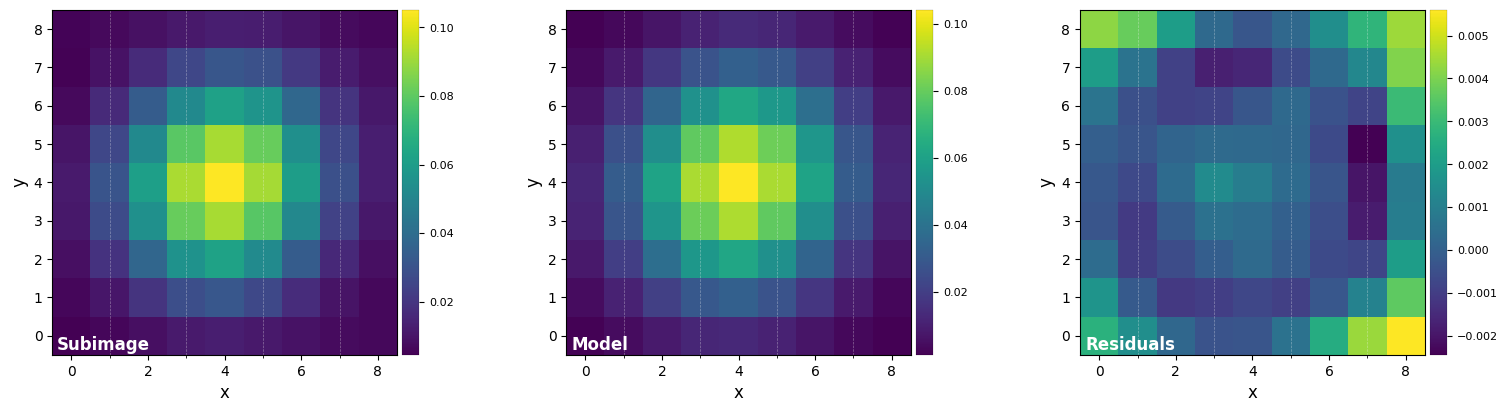

FWHM_y = 4.733218722257407
FWHM_x = 4.473682405059958 

centroid y = 19.006680059041216
centroid x = 18.999424475165455
centroid y subim = 4.006680059041214
centroid x subim = 3.9994244751654535 

amplitude = 0.10413004853269707
theta = -34.08563676836685


In [5]:
DF_fit = fit_2dgaussian(psf, crop=True, cropsize=9, debug=True, full_output=True)

In [6]:
fwhm_naco = np.mean([DF_fit['fwhm_x'],DF_fit['fwhm_y']])
print(fwhm_naco)

4.603450563658683


In [7]:
psfn = normalize_psf(psf, fwhm_naco, size=19, imlib='ndimage-fourier')

Flux in 1xFWHM aperture: 1.228


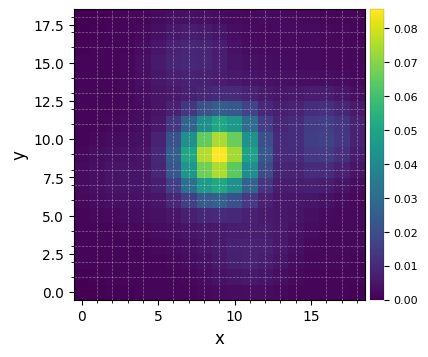

In [8]:
plot_frames(psfn, grid=True, size_factor=4)

In [9]:
cy, cx = vip.var.frame_center(cube)
pixels = pixels_in_annulus(cube.shape[1:], (cy, cx), 4,(cube.shape[1]-fwhm_naco)/2)

In [10]:
res = pca_annular(cube, angs, fwhm=fwhm_naco, asize=4, full_output=True, ncomp=10)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-05-10 17:25:26
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 12, FWHM = 4.603
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 13.13    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.086360
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.98    Ann center:   6    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.163890
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  6.95    Ann center:  10    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.271905
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  6.50    Ann center:  14    N segments: 1 
Done PCA with lapack for curr

In [11]:
cube_out, cube_der, frame = res

In [12]:
pca_fluxmap, pca_likelihoodmap_ = likelihoodmap(cube_out, angs, psfn, pixels, fwhm=fwhm_naco, norm=1, n_jobs=8)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 536 tasks      | elapsed:    8.9s
[Parallel(n_jobs=8)]: Done 1536 tasks      | elapsed:   15.2s
[Parallel(n_jobs=8)]: Done 2936 tasks      | elapsed:   23.9s
[Parallel(n_jobs=8)]: Done 4736 tasks      | elapsed:   36.1s
[Parallel(n_jobs=8)]: Done 6936 tasks      | elapsed:   53.3s
[Parallel(n_jobs=8)]: Done 7260 out of 7260 | elapsed:   55.5s finished


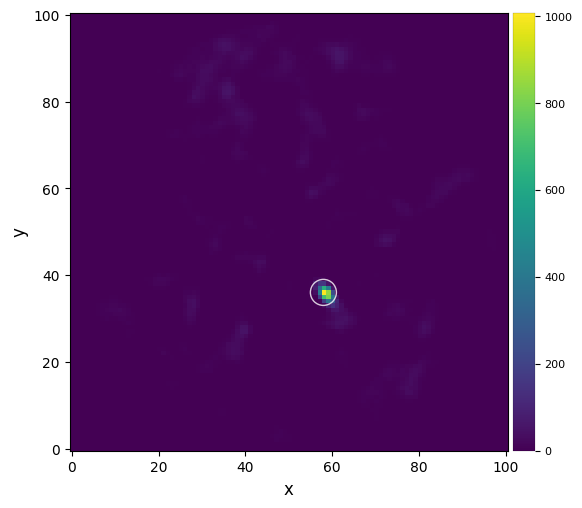

In [15]:
plot_frames(pca_likelihoodmap_, circle = (58,36), circle_radius=3)